### 問題設定
$x0 \in [0, 10]$の点を$T = f(x0)$で表されるTに$a \in \{*2, +1, end, -1, /2\}$から作用する演算を複数回用いて、なるべく速くたどり着くする。

これを多段意思決定問題として考えると、  
状態表現を$s \in \mathbb{R}^m$ 行動ベクトルを$a \in \mathbb{R}^n, a_i = \mathbb{I}(i = index \,of \,action)$とおくと、  
より速く目標値にたどり着くほど値が大きくなるような、報酬関数から得られる即時報酬の総和の期待値である
$$E[\sum_{t=0}^{T} \gamma^t R_t]$$
を最大化するような、  
ある状態に取る行動の条件付き確率である方策$\pi(a|s)$から、最良な方策$^*\pi(a|s)$を選ぶ問題として考えられる。

In [1]:
import torch as tc
from tqdm.notebook import tqdm
from torch.nn import functional as F
# 環境、結果の可視化、Tにたどり着くかの確認は別で切り分けた
# Agent, trainの部分のみnotebookで記述
from env_and_tools import ACTION_DIM, SPAN_LENGTH, Env, View, Test
from torch import nn
from torch.nn import functional as F
from torch import optim

device = tc.device('cuda:0')

from collections import defaultdict, namedtuple, deque
import random

Experience = namedtuple('Experience', ('s', 'a', 'ns', 'r', 'd'))

In [2]:
class LinearQualityFunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.affine = nn.Linear(state_dim, action_dim, bias=False)
        nn.init.constant_(self.affine.weight, 0)
        
    def forward(self, x):
        return self.affine(x)

In [3]:
class Agent(object):
    def __init__(self, state_dim, action_dim=ACTION_DIM, eps=0.1, lr=0.1, gamma=0.9):
        self.eps = eps
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.Q_function = LinearQualityFunction(state_dim, action_dim)
        self.Q_function.to(device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.Q_function.parameters(), lr=lr)
    
    def policy(self, s, play=False):
        if not play and tc.rand(()) < self.eps:
            return tc.randint(self.action_dim, ())
        with tc.no_grad():
            action_qualities = self.Q_function(s.v)
        return tc.argmax(action_qualities)
        
    def update(self, batch):
        estimation_qualities = []
        true_qualities = []
        for i, e in enumerate(batch):
            est = self.Q_function(e.s.v)
            v = e.r
            if not e.d:
                with tc.no_grad():
                    v += self.gamma * tc.max(self.Q_function(e.ns.v))
            estimation_qualities.append(est[e.a])
            true_qualities.append(v)
        estimation_qualities = tc.stack(estimation_qualities)
        true_qualities = tc.tensor(true_qualities).to(device)
        self.optimizer.zero_grad()
        loss = self.criterion(estimation_qualities, true_qualities)
        loss.backward()
        self.optimizer.step()

In [4]:
# 学習
# starts=[0, 3, 5, 8, 10]
starts = list(range(11))

def train(agent, seed=100, train_episode_num=100000):
    rewards_record_per_init = {key: [] for key in range(SPAN_LENGTH)}
    rewards_record_per_init['all'] = []
    
    # Experience Replay
    experiences = deque(maxlen=1024)

    for _ in tqdm(range(train_episode_num)):
        Ri = 0
        init = random.choice(starts)
        env = Env(init)
        s = env.state
        for _ in range(1000):
            # 行動を選択
            a = agent.policy(s)
            ns, r, d = env.step(a)
            e = Experience(s, a, ns, r, d)
            experiences.append(e)
            s = ns
            Ri = Ri + r
            if d:
                break
        if len(experiences) == 1024:
            batch = random.sample(experiences, 32)
            agent.update(batch)

        rewards_record_per_init[int(init)].append(Ri)
        rewards_record_per_init['all'].append(Ri)
    return {key: tc.tensor(r).to(device) for key, r in rewards_record_per_init.items()}

In [5]:
seed = 0
random.seed(seed)
tc.random.manual_seed(seed)
agent = Agent(state_dim=11, eps=0.1, lr=0.01)
R = train(agent, train_episode_num=1000)

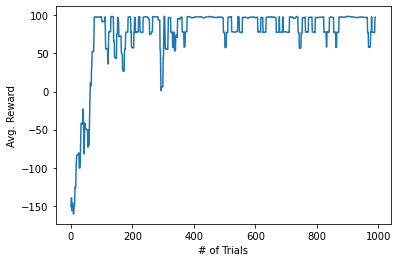

<Figure size 432x288 with 0 Axes>

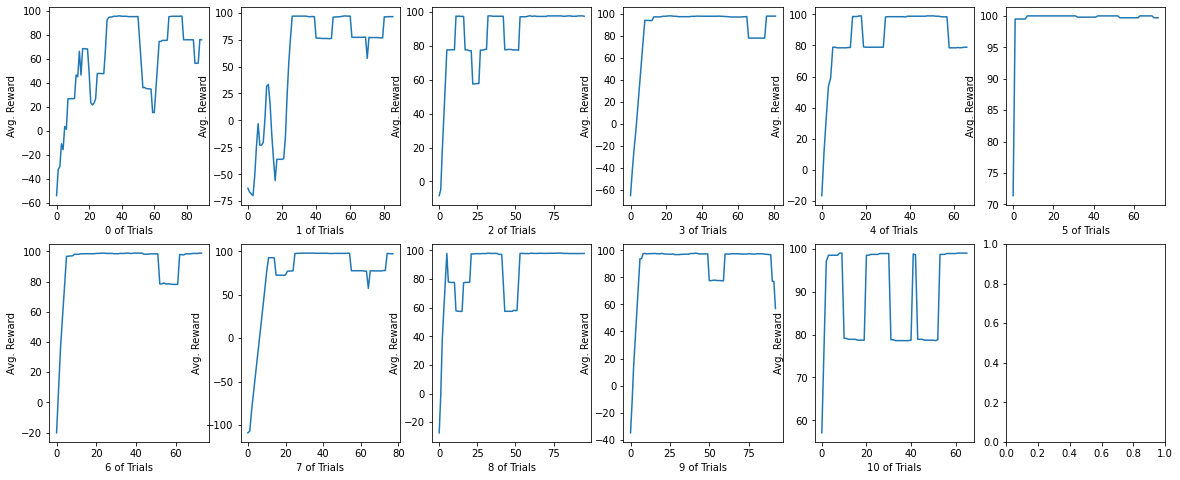

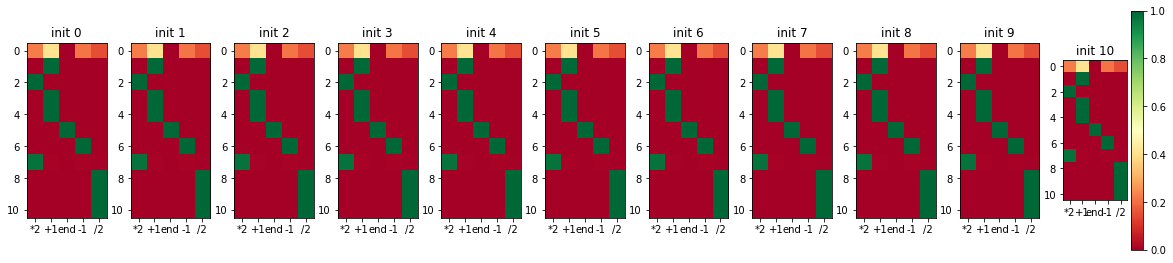

init = 0, T = 5, solved!

init = 1, T = 5, solved!

init = 2, T = 5, solved!

init = 3, T = 5, solved!

init = 4, T = 5, solved!

init = 5, T = 5, solved!

init = 6, T = 5, solved!

init = 7, T = 5, solved!

init = 8, T = 5, solved!

init = 9, T = 5, solved!

init = 10, T = 5, solved!



In [6]:
View.view(agent, R, n=10)
Test.test_all_init(agent)

In [7]:
from env_and_tools import act
act

['*2', '+1', 'end', '-1', '/2']

In [9]:
# print(next(agent.Q_function.parameters()).view(11, 5).cpu().detach().numpy())
params = list(agent.Q_function.parameters())
print(params)

[Parameter containing:
tensor([[-7.6958e-01,  1.1420e-01,  3.1964e+01, -3.8100e-02,  1.1661e-01,
          1.8687e+00,  1.4008e-01,  4.8170e+00, -1.3582e-02,  4.9975e-02,
         -3.8325e-02],
        [-1.5869e-01,  6.3031e+00,  5.1214e-02,  1.3695e+01,  7.4784e+01,
          9.6466e-01, -1.1208e-02,  3.1245e-02, -9.7279e-03,  2.9079e-01,
          6.1801e-01],
        [-9.4632e+00, -3.5009e+00, -4.1023e+00, -2.3479e+00, -5.1755e+00,
          9.8066e+01, -1.5508e+00, -2.2256e+00, -2.1032e+00, -1.7353e+00,
         -1.3043e+00],
        [-8.2663e-01, -3.4077e-01, -4.2041e-02,  1.0427e-01,  1.1702e-01,
          2.8852e+00,  2.3081e+01,  5.1487e-02,  1.1103e-02,  1.0074e-02,
          4.7051e-02],
        [-1.1673e+00, -3.4604e-01, -8.5062e-02, -8.4072e-02,  5.2729e-01,
          1.1440e+00, -5.8135e-02, -3.4685e-02,  1.3897e+01,  1.1261e+01,
          3.8122e+01]], device='cuda:0', requires_grad=True)]


In [10]:
for i in range(11):
    Test.test_specific_init(agent, i)
    print()

start from 0
T = 5
visited states [0, 1, 2, 4, 5, 5]
took actions ['+1', '+1', '*2', '+1', 'end']
got rewards [-1.0, -1.0, -1.0, -1.0, 100.0]

start from 1
T = 5
visited states [1, 2, 4, 5, 5]
took actions ['+1', '*2', '+1', 'end']
got rewards [-1.0, -1.0, -1.0, 100.0]

start from 2
T = 5
visited states [2, 4, 5, 5]
took actions ['*2', '+1', 'end']
got rewards [-1.0, -1.0, 100.0]

start from 3
T = 5
visited states [3, 4, 5, 5]
took actions ['+1', '+1', 'end']
got rewards [-1.0, -1.0, 100.0]

start from 4
T = 5
visited states [4, 5, 5]
took actions ['+1', 'end']
got rewards [-1.0, 100.0]

start from 5
T = 5
visited states [5, 5]
took actions ['end']
got rewards [100.0]

start from 6
T = 5
visited states [6, 5, 5]
took actions ['-1', 'end']
got rewards [-1.0, 100.0]

start from 7
T = 5
visited states [7, 10, 5, 5]
took actions ['*2', '/2', 'end']
got rewards [-1.0, -1.0, 100.0]

start from 8
T = 5
visited states [8, 4, 5, 5]
took actions ['/2', '+1', 'end']
got rewards [-1.0, -1.0, 100.0